In [1]:
import numpy as np
import os
import glob
import shutil
import matplotlib.pyplot as plt
import json
import subprocess
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 20
from IPython.display import Image
%matplotlib inline

# Lab 7 - Buckling behavior under biaxial compression

Module for computations

In [2]:
import FEM_utilities as FEM

## Write input file

Set parameters for simulation:

- *a*, *b*, *h*: geometry of plate
- **nx**, **ny**, number of elements in *x* and *y* directions
- **E**, $\nu$: elastic properties (Young modulus and Poisson ratio, as *TYPE* is by default **isotropic**) 
- $\gamma$: scale factor of $\sigma_y$ wrt $\sigma_x$
- *num_modes*: buckling modes to be computed (by default **1**)

Function *write_inp_file* defines:

- *filename* : name of input file
- *eltype* : type of shell element (see conventions [here](http://media.3ds.com/support/documentation/product/V6R2013/en/English/MpeUsbHtml/pt06ch29s06alm17.htm))
- *matname*: name of material
- *elname*: **\*Elset** assigned name
- *bc*, *load*: names for boundary condition, external and internal nodes loaded 
- *pa*, *pb*,*ax*, $\alpha$: coordinate points, axis and angle used to define local coordinate system (see conventions [here](http://media.3ds.com/support/documentation/product/V6R2013/en/English/MpeKeyHtml/ch15abk01.htm#usb-kws-morientation)) 
- *intpoints*: shell integration points

In [3]:
def write_inp_file(a, b, h, nx, ny, E, ν, γ, num_modes=1):
    """
    function to write inp file:
    a        : lenght of plate
    b        : height
    h        : thickness
    nx       : number of elements in x direction
    ny       : number of elements in y direction
    E        : Young's modulus
    nu       : Poisson ratio
    gamma    : sy = gamma*sx
    num_modes: number of eigenvalues to be estimated
    """
    
    elname = "EALL"
    matname = "mat1"
    
    
    bcs = ["x0_nodes", "xL_nodes", "y0_nodes", "yW_nodes"]
    
    sx_ext = 'loaded_nodes_ext_sx'
    sx_int = 'loaded_nodes_int_sx'
    sy_ext = 'loaded_nodes_ext_sy'
    sy_int = 'loaded_nodes_int_sy'

    
    pa = [1.0,0.0,0.0]
    pb = [0.0,1.0,0.0]
    # pc = [0.0,0.0,0.0]
    ax = 3
    α = 0.0
    
    intpoints = 5
    
    basename = 'p_nx'+str(nx).zfill(3)+'_ny'+str(ny).zfill(3)+'_g'+str(int(γ*100)).zfill(3)

    filename = basename+'.inp'
    
    outfile = open(filename, "wt")
    
    outfile.write("** Lab 07 input file - buckling of plate under biaxial load\n")
        
    nodes, elements, y0, yL, x0, xW = FEM.NodesLab07(nx, ny, a, b)
    
    bc_nodes = [y0, yL, x0, xW]
        
    # NODES section
    outfile.write("**\n")
    outfile.write("** Nodes\n")
    outfile.write("**\n")
    outfile.write("*NODE, nset = nglobal\n")

    for i in range(nodes.shape[0]):
        nodestring = "{0:4d}".format(int(nodes[i,0]))
        for j in range(1,nodes.shape[1]):
            nodestring+=",{0:8}".format(nodes[i,j])
        nodestring+="\n"
        outfile.write(nodestring)
        
    # ELEMENTS section
    outfile.write("**\n")
    outfile.write("** Elements\n")
    outfile.write("**\n")
    outfile.write("*ELEMENT, type = S4R\n")
    
    for i in range(elements.shape[0]):
        elstring = "{0:4d}".format(int(elements[i,0]))
        for j in range(1,elements.shape[1]):
            elstring+=",{0:4d}".format(int(elements[i,j]))
        elstring+="\n"
        outfile.write(elstring)

    # MATERIAL section
    outfile.write("**\n")
    outfile.write("** Materials\n")
    outfile.write("**\n")
    outfile.write("*MATERIAL, name = {0}\n".format(matname))
    outfile.write("*Elastic\n")
    outfile.write("{0},{1:6}\n".format(E,ν))

    # SETS section
    # NODES
    outfile.write("**\n")
    outfile.write("** Sets\n")
    outfile.write("**\n")
    
    for i, bc in enumerate(bcs):
        outfile.write("*NSET, nset = {0}\n".format(bc))
        
        n_lines = np.ceil(len(bc_nodes[i])/16)
        
        for i_line in range(int(n_lines)):
            bc_str = "{0:4d}".format(int(bc_nodes[i][16*i_line]))
            
            for j in range(16*i_line+1,min(len(bc_nodes[i]),16*(i_line+1)) ):
                bc_str+=",{0:4d}".format(int(bc_nodes[i][j]))
            bc_str+="\n"
            outfile.write(bc_str)
        
        # il seguente funziona se <= 16
        #bc_str = "{0:4d}".format(int(bc_nodes[i][0]))
        #for j in range(1,len(bc_nodes[i])):
        #     bc_str+=",{0:4d}".format(int(bc_nodes[i][j]))
        #bc_str+="\n"
        #outfile.write(bc_str)
        
    # loaded
    
    # SIGMA x
    if len(yL > 2):
        outfile.write("*Nset, nset = {0}\n".format(sx_int))
        
        yLint = yL[1:-1]
        
        n_lines = np.ceil(len(yLint)/16)
        
        for i_line in range(int(n_lines)):
            il_str = "{0:4d}".format(int(yLint[16*i_line]))
            for j in range(16*i_line+1,min(len(yLint),16*(i_line+1)) ):
                il_str+=",{0:4d}".format(int(yLint[j]))
            il_str+="\n"
            outfile.write(il_str)
    
    outfile.write("*Nset, nset = {0}\n".format(sx_ext))
    el_str = "{0:4d},{1:4d}\n".format(int(yL[0]),int(yL[-1]))
    outfile.write(el_str)
    
    # SIGMA y
    if len(xW > 2):
        outfile.write("*Nset, nset = {0}\n".format(sy_int))
        
        xWint = xW[1:-1]
        
        n_lines = np.ceil(len(xWint)/16)
        
        for i_line in range(int(n_lines)):
            il_str = "{0:4d}".format(int(xWint[16*i_line]))
            for j in range(16*i_line+1,min(len(xWint),16*(i_line+1)) ):
                il_str+=",{0:4d}".format(int(xWint[j]))
            il_str+="\n"
            outfile.write(il_str)
    
    outfile.write("*Nset, nset = {0}\n".format(sy_ext))
    el_str = "{0:4d},{1:4d}\n".format(int(xW[0]),int(xW[-1]))
    outfile.write(el_str)
    
    # ELEMENTS
    outfile.write("*Elset, elset = {0}, generate\n".format(elname))
    outfile.write("{0:4d},{1:4d},{2:4d}\n".format(1,elements.shape[0],1))
    
    # ORIENTATION
    outfile.write("**\n")
    outfile.write("** LOCAL ORIENTATION\n")
    outfile.write("**\n")
    outfile.write("*orientation, name = local_orientation\n")
    outfile.write("".join(str(pa+pb))[1:-1])
    outfile.write("\n")
    outfile.write("{0},{1:4}\n".format(ax,α))

    # SHELL PROPERTIES
    outfile.write("**\n")
    outfile.write("** SHELL PROPERTIES\n")
    outfile.write("**\n")
    outfile.write("*Shell Section, elset = {0}, material = {1}, orientation = local_orientation\n" \
                  .format(elname,matname))
    outfile.write("{0:4},{1:4d}\n".format(h,intpoints))
    
    # calculation steps
    outfile.write("**\n")
    outfile.write("** STEP\n")
    outfile.write("**\n")
        
    
    outfile.write("*STEP\n")
    outfile.write("*BUCKLE\n")
    outfile.write("{0},\n".format(num_modes))
    
    # BOUNDARY CONDITIONS
    outfile.write("**\n")
    outfile.write("** BOUNDARY CONDITIONS\n")
    outfile.write("**\n")
    outfile.write("*Boundary\n")
    for bc in bcs:
        outfile.write("{0}, 3\n".format(bc))
    
    outfile.write("{0}, 1\n".format(bcs[0]))
    outfile.write("{0}, 2\n".format(bcs[2]))
    
    # LOADS
    outfile.write("**\n")
    outfile.write("** LOADS\n")
    outfile.write("**\n")
    outfile.write("*Cload\n")
    #outfile.write("{0}, {1:2d}, {2}\n".format(loadnodes, 2, -0.5 ))
    if len(bcs[1]) > 2:
        outfile.write("{0}, {1:2d}, {2}\n".format(sx_int, 1, -1.0*(b*h)/ny ))
    outfile.write("{0}, {1:2d}, {2}\n".format(sx_ext, 1, -0.5*(b*h)/ny ))
    
    if len(bcs[3]) > 2:
        outfile.write("{0}, {1:2d}, {2}\n".format(sy_int, 2, -1.0*(a*h)*γ/nx ))
    outfile.write("{0}, {1:2d}, {2}\n".format(sy_ext, 2, -0.5*(a*h)*γ/nx ))

    
    outfile.write("*NODE FILE, LAST MODE={0}\n".format(num_modes))
    outfile.write("U, RF\n")
    #outfile.write("*EL FILE, ELSET=PRINT, LAST MODE={0}\n".format(num_modes))
    #outfile.write("ENER,\n")
    #outfile.write("ELEN,\n")
    outfile.write("*END STEP\n")        
    outfile.close()
    
    if not os.path.exists('../Lab07_abaqus/'+basename+'/'):
        os.makedirs('../Lab07_abaqus/'+basename+'/')

    shutil.move(filename,'../Lab07_abaqus/'+basename+'/'+filename)

Parameters:

In [4]:
a = 700. # lenght [mm]
b = 350.  # width  [mm]
h = 1.3   # thickness [mm]


Compute node coordinates, elements, constrained and loaded nodes

In [5]:
E = 72000. # modulus [MPa]
ν = 0.33   # Poisson's coefficient

nx = [7,14,14,50,100]
ny = [7,7,14,50,50]

#test many nodes
#nx = [50,100]
#ny = [50,50]

# list of gammas
γ_v = [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 4.0, 6.0, 7.5, 9.0]

#test
#γ_v = [1.0]


if len(nx) == len(ny):
    for i in range(len(nx)):
        for γ_act in γ_v:
            write_inp_file(a, b, h, nx[i], ny[i], E, ν, γ_act)
else:
    print("nx and ny vector lenghts don't match")

In [6]:
def generateCases(loc, prefix):
    """
    generates all cases from specified root directory and starting with prefix
    loc : root directory
    """
    curr_dir = os.getcwd()
    
    if not loc.startswith("/"):
        #relativer path
        base_dir = os.path.abspath(loc)
    else:
        base_dir = loc
    
    #print(curr_dir)
    dirs = glob.glob(loc+"/"+prefix+"*")
    
    command = ['/usr/simulia/abaqus/Commands/abaqus']
    
    options = [['datacheck','interactive'],['interactive','continue']]
    
    for di in dirs:
        test = di.split('/')[-1]
        os.chdir(di)
        job="j={0}".format(test)
        
        for opt in options:
            subprocess.call(command+[job]+opt)
        
        os.chdir(base_dir)
        
    os.chdir(curr_dir)

##Generate Abaqus cases

In [7]:
# commented out as already computed:
#generateCases("../Lab07_abaqus/","p_")

## Analytical solution:

$\sigma_x = \frac{\pi^2}{b^2} \cdot \frac{1}{h} \cdot Dk$

$k = \frac{\left[ \left( \frac{m}{r} \right)^2 + n^2 \right]^2}{\left( \frac{m}{r} \right)^2 + \gamma n^2} \quad m,n = 1 \ldots \infty $

$\sigma_{y} = \gamma \cdot \sigma_{x}$

$r = \frac{a}{b} \quad D = \frac{E h^3}{12\left(1-\nu^2\right)}$


In [8]:
r = a/b

D = E*h**3/(12*(1-ν**2))

γ_a = np.linspace(0.0,10.0, 10000)

σ_x = np.zeros_like(γ_a)
σ_y = np.zeros_like(γ_a)

k_a = np.zeros_like(γ_a)
m_min = np.zeros_like(γ_a)
n_min = np.zeros_like(γ_a)

for i, γ in enumerate(γ_a):
    m_min[i] = 0
    n_min[i] = 0
    k_a[i] = np.inf
    for m in range(1,15):
        for n in range(1,15):
            k_tmp = ((m/r)**2 + n**2)**2/((m/r)**2+γ*n**2)
            if k_tmp < k_a[i]:
                k_a[i] = k_tmp
                m_min[i] = m
                n_min[i] = n
    
    σ_x[i] = np.pi**2/b**2*D*k_a[i]/h
    σ_y[i] = γ * σ_x[i]
        



#Simulations Data

In [9]:
def readDataL07(filename):
    
    file=open(filename,'r') 
    row = file.readlines()
    
    eig = -1.0
    
    for line in row:
        strlist = line.split()
        if len(strlist) == 2:
            if strlist[0] == '1':
                eig = np.abs(float(strlist[1]))
                break
    file.close()
    return eig


In [10]:
dirs = glob.glob("../Lab07_abaqus/p_*")

p_eig = {}


for di in dirs:
    test = di.split('/')[-1]
    a = readDataL07(di+"/"+test+".dat")
    if a != -1.0:
        if test[2:13] not in p_eig:
            p_eig[test[2:13]] = [[],[]]
        p_eig[test[2:13]][0].append(a)
        p_eig[test[2:13]][1].append(a*float(test[-3:])/100)

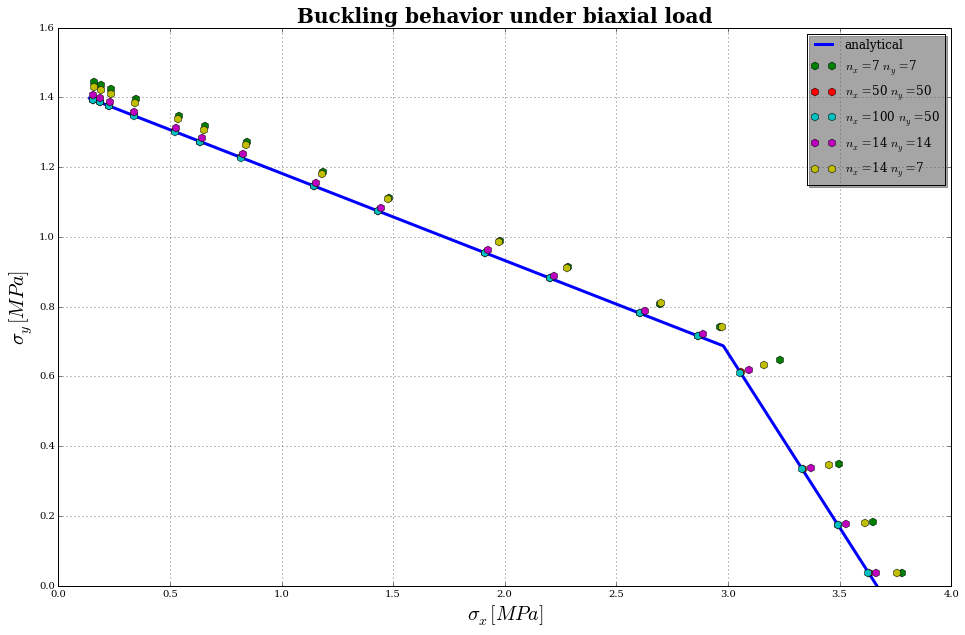

In [11]:
plt.figure(figsize=(16,10), dpi=300)
plt.plot(σ_x, σ_y, lw=3., label='analytical')

for act_test in p_eig:
    lb = r'$n_x=$'+str(int(act_test[2:5]))+' $n_y=$'+str(int(act_test[8:11]))
    plt.plot(p_eig[act_test][0],p_eig[act_test][1],'h',ms=8,label=lb)

#plt.xlim([0.,4])
#plt.ylim([0.0,1.6])
plt.xticks(np.arange(0.,4.1,0.5))
plt.yticks(np.arange(0.0,1.61,.2))
plt.title('Buckling behavior under biaxial load', fontsize=20, fontweight="bold")
plt.xlabel(r'$\sigma_x [MPa]$', fontsize=20)
plt.ylabel(r'$\sigma_y [MPa]$', fontsize=20)
plt.legend(loc='upper right', shadow=True)
plt.grid()
plt.savefig('Lab07.jpg');

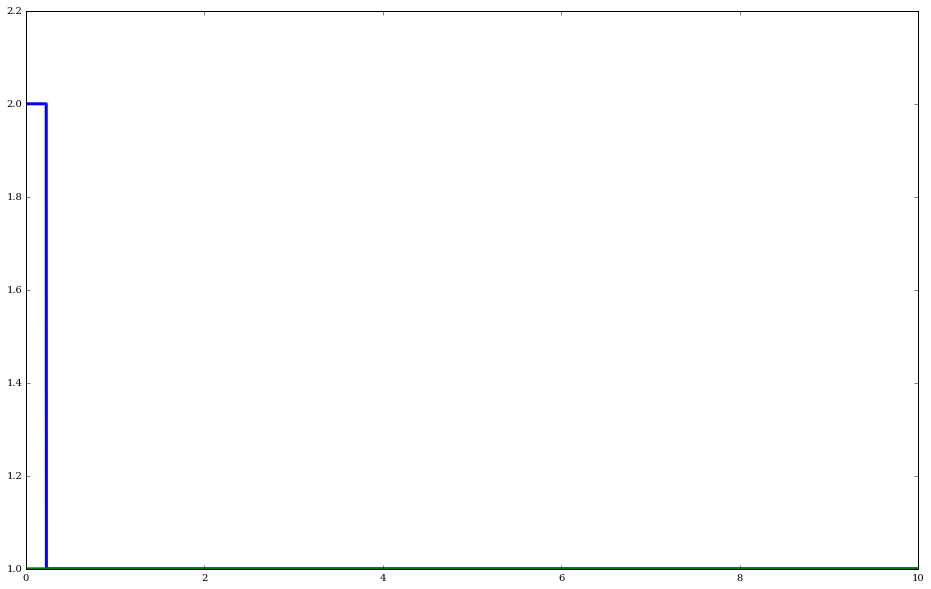

In [12]:
plt.figure(figsize=(16,10), dpi=300)
plt.plot(γ_a, m_min, lw=3.,label='m')
plt.plot(γ_a, n_min, lw=3.,label='n')